In [1]:
%matplotlib inline

import numpy as np
from numpy import random
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import itertools
import seaborn as sns
import os
print(os.getcwd())
import sys
Path = os.getcwd()
sys.path.append(Path)
from build_network import *
from utilities1 import simulated_SNR, psd, psd_Vm, save_figure



/mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Oct 15 2023 15:12:16

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
def plot_results(sim_time=5000, noisy=False, delay_mean=1.0, delay_sd=0.25,  
                 second_sine=False,xLim=1, y_min=1e-12,a_values=[100], SD_values=[250],
                 f_values=[10], beat=20, E_m=-60, V_th=-50, bin_size=0.25, tau_m=10,
                 seed=np.random.randint(0,1e+6), resolution=0.25, num_A=1000,
                 log=True, harmonics=1, harmonics_beat=0, V_thresh=-50,
                 measure_from_A=False, seed_check=False):
    """This function plots:
    - Membrane potential as a function of time for a given length within simulation time (xLim)
    - The PSD of the spike train
    - The PSD of the membrane potential
        noisy: whether to include noise or not (True/False)
        sim_time: duration of simulation (ms)
        psd_segments: number of segments in welch psd
        second_sine : whether to include second AC generator or not (True/False)
        xLim : limiting the time axis of the membrane potential (max value) (ms)
        a_values : input amplitudes (pA)
        SD_values : input noise level (standard deviation) (pA)
        f_values : input frequencies (Hz)
        beat : frequency offset (Hz)
        E_m : resting potential (mV)
        V_th : Threshold for firing action potentials (mV)
        bin_size : width of frequency (Hz)
        seed : random number (or set by user for control).
        Necessary for generation of stochastic noise,
        resolution : temporal resolution/length of time steps (ms)
        legend : Whether to put legend outside plots (True/False)
        log : Whether to use loglog-plot or not (True/False)
        y_min : min value for PSD of spike train (varies a lot)
        harmonics : number of harmonics of input frequencies indicated in PSD-plot
        harmonics_beat : number of harmonics of beat frequency indicated in PSD- plot
        measure_from_A : whether to measure from a neuron in population A instead of B (True/False)
        seed_check : whether to plot membrane potentials for two neurons in pop. A (True/False)"""

    
    ###*************************SIMULATION**************************************
    if noisy:
        param_combos = list(itertools.product(f_values,a_values, SD_values))
        
    else:
        param_combos = list(itertools.product(f_values, a_values))
    
    param_combos = np.atleast_1d(param_combos) #to allow for one single combination
    
    
    fig, axes = plt.subplots(nrows=len(param_combos), ncols=3, 
                             figsize=(15, 4*len(param_combos)))
    
    if len(param_combos) == 1:
        axes = np.array([axes])
    
    for idx, combo  in enumerate(param_combos):
        if noisy:
            f, a, sd = combo
            results = build_network(sim_time=sim_time, noisy=True, second_sine=second_sine, V_thresh=V_th,
                                        f1=f, beat=beat, a=a, SD=sd, tau_m=tau_m, num_A=num_A,
                                        seed=seed, resolution=resolution, measure_from_A=measure_from_A, 
                                        delay_mean=delay_mean, delay_sd=delay_sd)   
            
        else:
            f,a = combo
            results = build_network(sim_time=sim_time, second_sine=second_sine, noisy=noisy, 
                                    f1=f, a=a, delay_mean=delay_mean, delay_sd=delay_sd, 
                                    V_thresh=V_th, E_m=E_m, tau_m=tau_m, num_A=num_A, 
                                    seed=seed, beat=beat, resolution=resolution, measure_from_A=measure_from_A)
                

         #********************************RESULTS AND PLOTS********************************   
        spike_times = results["spike_times"]
        Vm = results["Vm"]
        V_th = results["V_th"]
        sim_time = results["sim_time"]
        times = results["times"]
        tot_spike_rate = results["tot_spike_rate"]
        
        
        # Layout
        sns.set_style("whitegrid")
        plt.rcParams["font.family"] = "Liberation Serif"
        
        # Membrane potential with threshold 
       
        ax_vm = axes[idx,0]
            
        time_axis = np.linspace(0,sim_time,len(Vm))
        
        for t in spike_times:
            ax_vm.vlines(x=t, ymin=V_th, ymax=V_th+5, color="black") 
            
        ax_vm.plot(times, Vm, color='#006D5B')
        ax_vm.axhline(V_th, linestyle='-', color='black', label="V_th")  # terskel-linje
        
        
        # Setting title based on configuration of simulation
        letters = "ABCDEFGHIJKLMN"
        
        if noisy:
            if second_sine:
                ax_vm.set_title(
                rf"{letters[idx*3]}. Vm ($f_1$ = {f:.0f}Hz, $f_2$ = {f + beat :.0f}Hz, " +
                rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)",
                fontsize=16, fontweight='bold', color="#006D5B"
                )
            else:
                ax_vm.set_title(
                rf"{letters[3*idx]}. Vm ($f$ = {f:.0f}Hz, $\sigma_I$ = {sd:.0f}pA, " +
                rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)",
                fontsize=16, fontweight='bold', color="#006D5B"
                )
        else:
            if second_sine:
                ax_vm.set_title(
                rf"{letters[3*idx]}. Vm ($f_1$ = {f:.0f}Hz, $f_2$ = {f + beat:.0f}Hz, " +
                rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)",
                fontsize=16, fontweight='bold', color="#006D5B"
                )
            else:
                ax_vm.set_title(
                rf" Vm ($f$ = {f:.0f}Hz, $I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)",
                fontsize=16, fontweight='bold', color="#006D5B")
                
                
            # removing frequencies from the title if the input amplitude is zero
        if a == 0:
            title = title.replace(r"($f$ = " + f"{f:.0f}" + r"Hz, ", "(")
            title = title.replace(r"($f_1$ = " + f"{f:.0f}" + r"Hz, $f_2$ = " + f"{f + beat:.0f}" + r"Hz, ", "(")

            
        ax_vm.set_xlim([1000, 1000+xLim*1000])
        if np.all(Vm!=-60):
            ax_vm.set_ylim([np.min(Vm)-5,np.max(Vm)+10])
        else:
            ax_vm.set_ylim(np.min(Vm)-5, np.max(Vm)+10)
        ax_vm.set_xlabel("Time [ms]", color="#006D5B", fontsize=16)
        ax_vm.set_ylabel(r"$V_\mathrm{m}\, [\mathrm{mV}]$", color="#006D5B", fontsize=16)
        
        #chat-gpt:
        ax_vm.set_facecolor("#F5F5F5")
        ax_vm.spines["top"].set_visible(False)
        ax_vm.spines["right"].set_visible(False)
        ax_vm.spines["left"].set_color("#333333")
        ax_vm.spines["bottom"].set_color("#333333")
        ax_vm.xaxis.label.set_color("#006D5B")
        ax_vm.yaxis.label.set_color("#006D5B")
        ax_vm.tick_params(axis='both', colors="#333333")
        ax_vm.legend(facecolor="white", framealpha=1, edgecolor="#333333")
    
    
        
        # PSD of spike train
        freqs, psd_values = psd(spike_times, sim_time, bin_size)
        freqs = freqs[50:]
        psd_values = psd_values[50:]
        arg_f = np.argmin(np.abs(freqs - f))
        
        if second_sine:
            arg_beat = np.argmin(np.abs(freqs - beat))
        else:
            arg_beat = None
        
        ax_fft = axes[idx,1]
        
        # Vertical lines indicating harmonics, colors filled in by chat GPT
        beat_colors = ["teal", "#1E3A8A", "#2563EB", "#60A5FA", "#38BDF8"] #Blue colors for beat frequencies
        colors = ["#009879", "#4CAF50", "#8BC34A", "#CDDC39", "#FFEB3B", "#FF9800","#F4E91E63","#9C27B0","#673AB7", 
    "#3F51B5"] # Green colors for harmonics
        
        for i in range(1,harmonics_beat+1):
            ax_fft.axvline(i*beat, linestyle="--", dashes=(2, 5), color=beat_colors[i], label=f"f={i*beat}Hz")
            
        for i in range(1,harmonics+1):
            ax_fft.axvline(i*f, linestyle="--", dashes=(2, 5), color=colors[i], label=f"{i*f}Hz")
            if second_sine:
                ax_fft.axvline(i*(f+beat), linestyle="--", dashes=(2, 5), color=colors[i+harmonics], label=f"{i*(f+beat)}Hz")
            ax_fft.legend()
        
        ax_fft.plot(freqs, psd_values, color="#006D5B") 
        
        xMax = max(f,np.max(freqs))*1.1
        if log:
            ax_fft.set_xscale("log")
            ax_fft.set_yscale("log")
            # xticks and yticks
            ax_fft.xaxis.set_major_locator(LogLocator(base=10.0)) 
            ax_fft.yaxis.set_major_locator(LogLocator(base=10.0))
            
        ax_fft.set_xlabel("Frequency (Hz)", color="#006D5B", fontsize=16)
        ax_fft.set_ylabel(r'PSD [$\mathrm{spikes}^2/\mathrm{Hz}$]', color="#006D5B", fontsize=16)
        ax_fft.set_title(f"{letters[1+3*idx]}. PSD of spike train", fontsize=18, fontweight='bold', color="#006D5B")
        
        # Generated by ChatGPT (modified)
        ax_fft.set_facecolor("#F5F5F5")
        ax_fft.spines["top"].set_visible(False)
        ax_fft.spines["right"].set_visible(False)
        ax_fft.spines["left"].set_color("#333333")
        ax_fft.spines["bottom"].set_color("#333333")
        ax_fft.xaxis.label.set_color("#006D5B")
        ax_fft.yaxis.label.set_color("#006D5B")
        ax_fft.tick_params(axis='both', colors="#333333", labelsize='large')
        ax_fft.legend(facecolor="white", framealpha=1, edgecolor="#333333",loc='lower left')
        
        # table of important values
        if noisy:
            if second_sine == False:
                beat = 0
            df, noise_avg = simulated_SNR(Vm, a, psd_values, f, freqs, 
                                          arg_f, sim_time, sd, beat, spike_times, second_sine)
                      
            df["Population spike-rate"] = tot_spike_rate
            display(df)
    
    
        # PSD of membrane potential
        freqs, fft_vm = psd_Vm(Vm, times, bin_size)
        fft_vm = np.abs(fft_vm)
        
        ax_fft_vm = axes[idx,2]
        for i in range(1,harmonics_beat+1):
            ax_fft_vm.axvline(i*beat, linestyle="--", dashes=(2, 5), color=beat_colors[i], label=f"{i*beat}Hz")
            
        for i in range(1,harmonics+1):
            ax_fft_vm.axvline(i*f, linestyle="--", dashes=(2, 5), color=colors[i], label=f"{i*f}Hz")
            if second_sine:
                ax_fft_vm.axvline(i*(f+beat), linestyle="--", dashes=(2, 5), color=colors[i+harmonics], label=f"{i*(f+beat)}Hz")
            
        ax_fft_vm.legend()    
        ax_fft_vm.plot(freqs, np.abs(fft_vm), color='#006D5B')  
        ymin = max(y_min, np.min(np.abs(fft_vm)))
        ax_fft_vm.set_ylim(ymin,10*np.max(np.abs(fft_vm)))
        ax_fft_vm.set_xlabel("Frequency [Hz]", color="#006D5B", fontsize=16)
        ax_fft_vm.set_ylabel(r'PSD [$(\mathrm{mV})^2/\mathrm{Hz}$]', color="#006D5B", fontsize=16)
        ax_fft_vm.set_title(f"{letters[2+3*idx]}. PSD of $V_m$", fontsize=20, fontweight='bold', color="#006D5B")
        if np.any(Vm!=-60): 
            ax_fft_vm.set_xscale("log")
            ax_fft_vm.set_yscale("log")
            ax_fft_vm.xaxis.set_major_locator(LogLocator(base=10.0))
            ax_fft_vm.yaxis.set_major_locator(LogLocator(base=10.0))
        
        #generated by chatGPT
        ax_fft_vm.set_facecolor("#F5F5F5")
        ax_fft_vm.spines["top"].set_visible(False)
        ax_fft_vm.spines["right"].set_visible(False)
        ax_fft_vm.spines["left"].set_color("#333333")
        ax_fft_vm.spines["bottom"].set_color("#333333")
        ax_fft_vm.xaxis.label.set_color("#006D5B")
        ax_fft_vm.yaxis.label.set_color("#006D5B")
        ax_fft_vm.tick_params(axis='both', colors="#333333", labelsize='large')
        ax_fft_vm.legend(facecolor="white", framealpha=1, edgecolor="#333333")
        
        
    if seed_check:
        plt.figure()
        plt.plot(results["times"], results["Vm"])
        plt.plot(results["times2"], results["Vm2"], linestyle="--")
        plt.xlim(100,500)
        plt.title("Making sure noise varies within the population")

    
    plt.tight_layout()
    save_figure("B_main")
    plt.show()
        

len psd values 12201, arg_f 6200
noise_avg for f 4.77856823993423


,Input Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],FFT Amplitude for f [(spikes pr sec)/Hz],Frequency at max (Hz),SNR,noise average,Spike Rate (spikes/s),Population spike-rate
0,1000,100,-50.000126,9.57,4.84,1144.16,1.01,4.78,2.42,2334.07


len psd values 12201, arg_f 6200
noise_avg for f 5.558950659745209


,Input Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],FFT Amplitude for f [(spikes pr sec)/Hz],Frequency at max (Hz),SNR,noise average,Spike Rate (spikes/s),Population spike-rate
0,1000,300,-50.002336,19.96,19.96,1000.0,3.59,5.56,2.67,2546.11


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


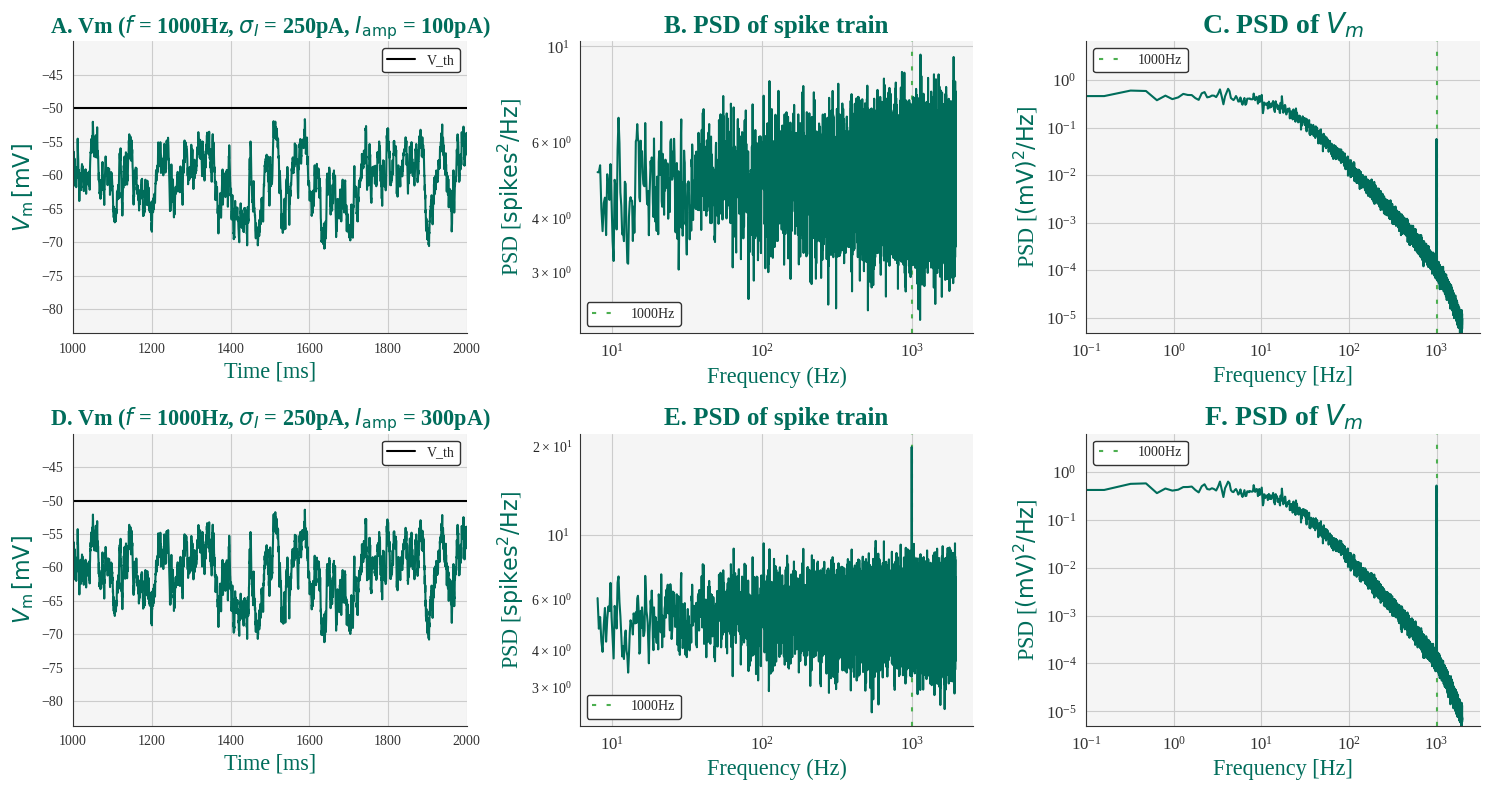

In [ ]:
plot_results(sim_time=100e3, SD_values=[250],
             a_values=[100,300],f_values=[1000],measure_from_A=True,
             noisy=True, xLim=1, seed=42, bin_size=0.25, second_sine=False,
            harmonics=1, resolution=0.25, y_min=1e-16)

## Receiving neuron

Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


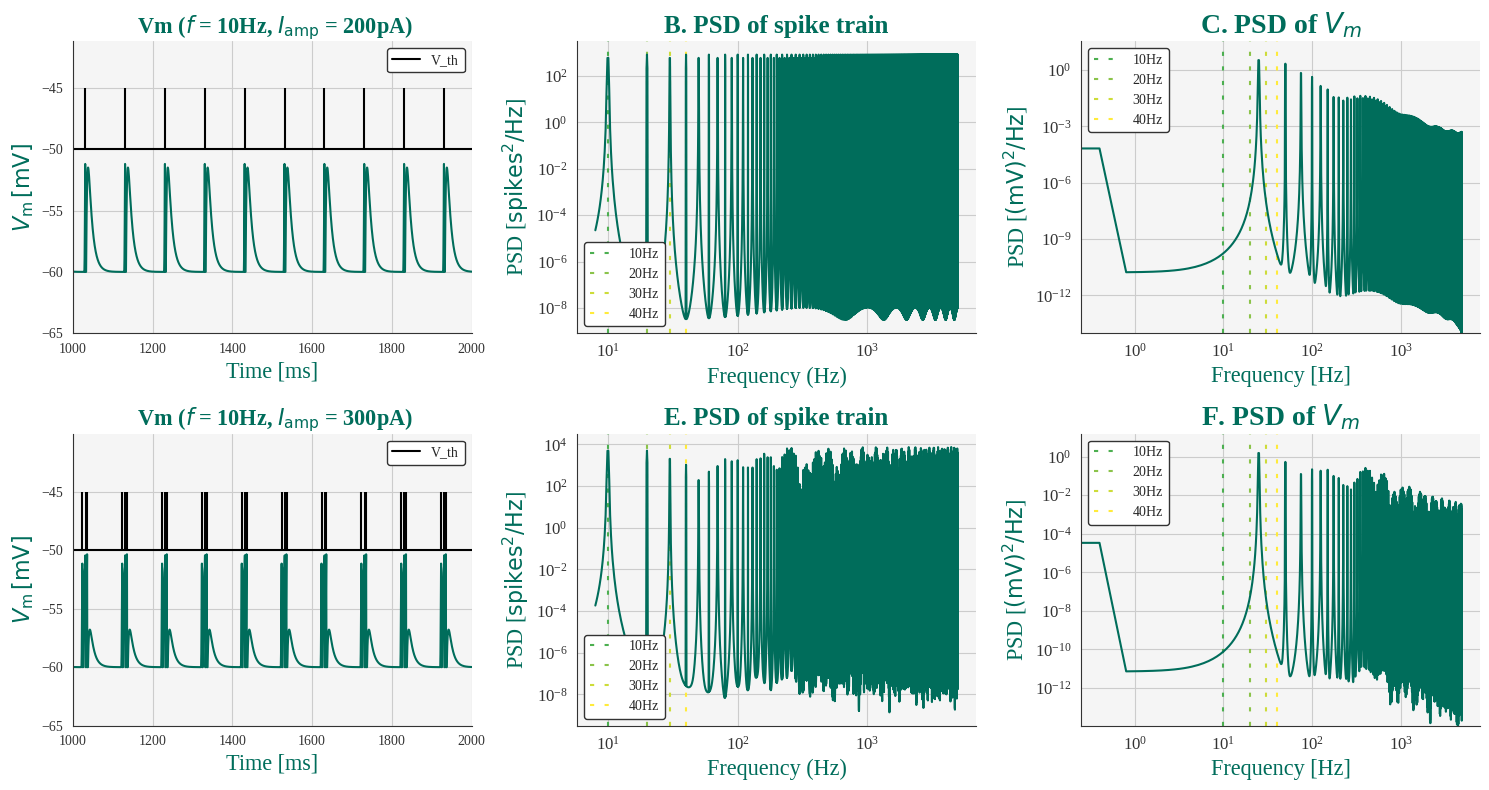

In [8]:
plot_results(sim_time=100e3, delay_sd=0.25, delay_mean=1,
             a_values=[200,300], V_th=-50, f_values=[10],
             noisy=False, SD_values=[0],num_A=1000, y_min=1e-15,
             bin_size=0.1,xLim=1,second_sine=False, harmonics=4,
            save_fig=True, log=True, resolution=0.25, weight=1)


May 15 09:03:56 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 0.25 ms

May 15 09:03:56 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.25 ms.
len psd values 12201, arg_f 12
noise_avg for f 3.83918983276899


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[10, 30]",20,100,-50.001582,19.35,19.35,19.05,9.92,5.04,3.84,1.99,5.2,3.7,4514.42


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


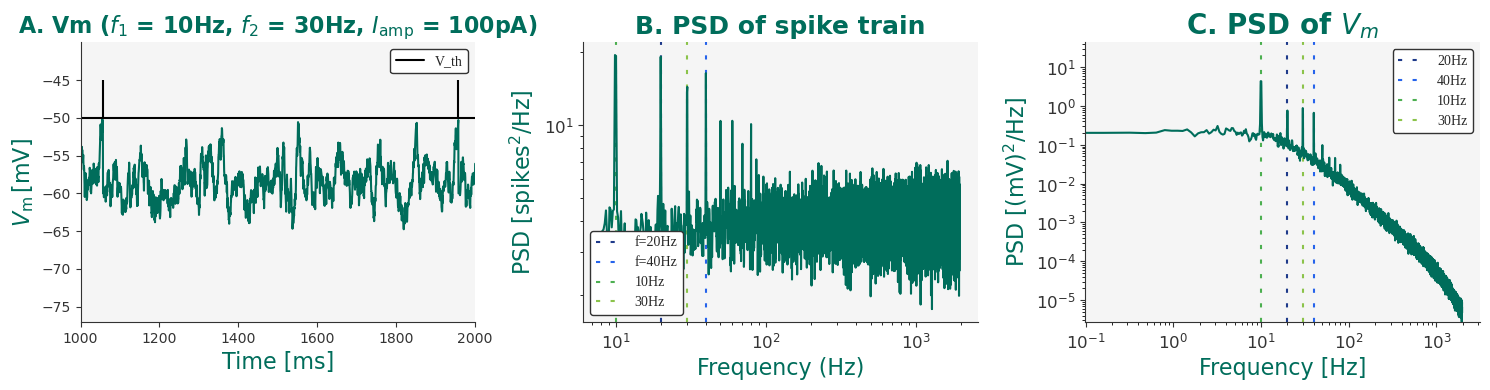

In [3]:
plot_results(sim_time=100e3,
             a_values=[100],f_values=[10], delay_sd=0.25, delay_mean=1,
             noisy=True, SD_values=[250],num_A=1000, seed=5,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=2,harmonics=1,
            save_fig=True, log=True, resolution=0.25, weight=1)


May 15 23:41:41 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 0.25 ms

May 15 23:41:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.25 ms.


/tmp/ipykernel_334/2418252097.py:155: UserWarning:Data has no positive values, and therefore cannot be log-scaled.
/mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/utilities1.py:143: RuntimeWarning:invalid value encountered in double_scalars


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,2500,-54.349598,0.0,0.0,0.0,8.0,NaN,0.0,0.0,NaN,0.0,3346.92


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,3000,-50.13004,0.0,0.0,0.0,1100.0,1.0,0.0,0.01,1.0,0.0,6042.34


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


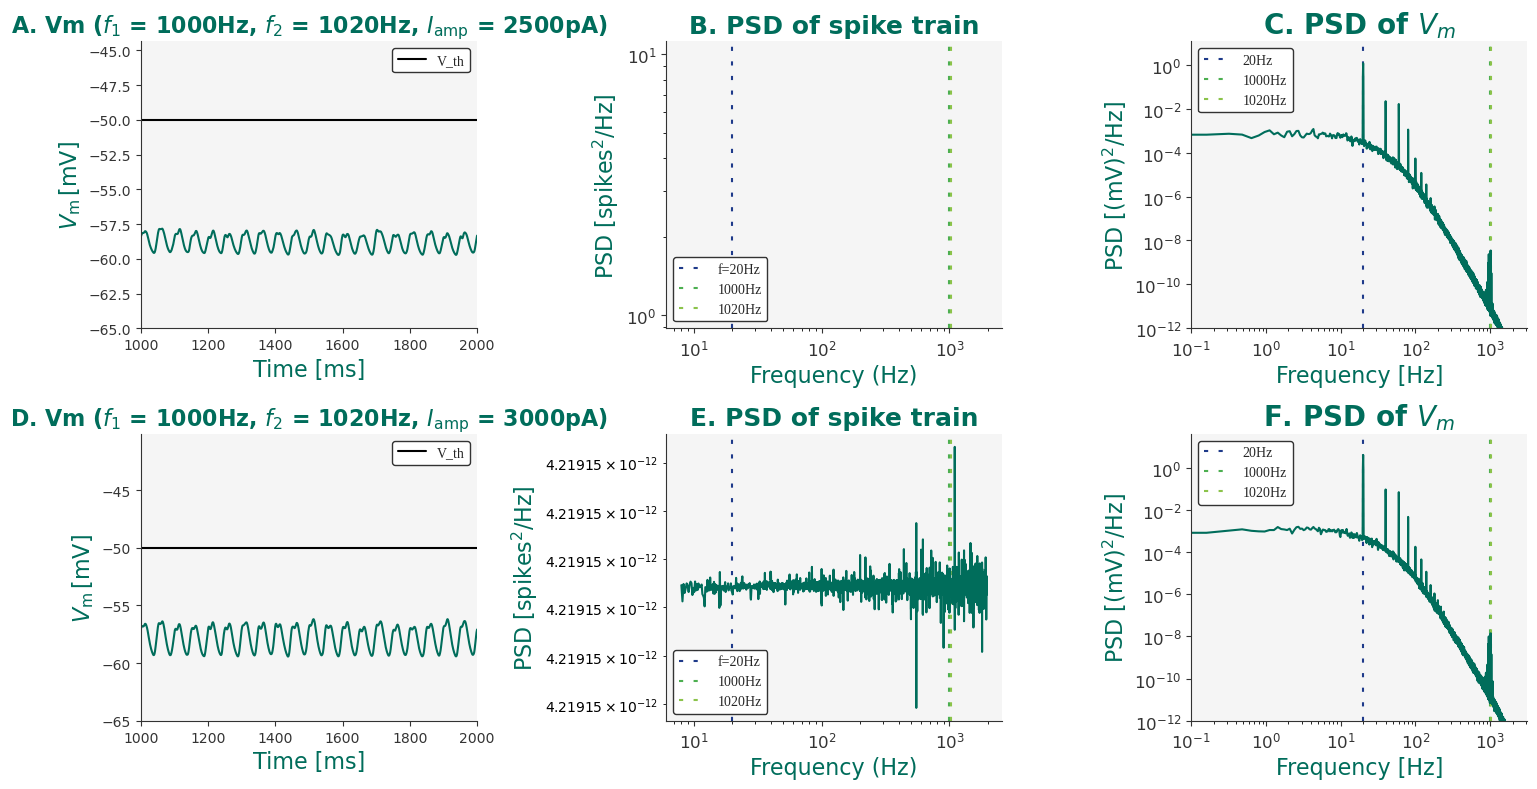

In [4]:
plot_results(sim_time=100e3,
             a_values=[2500,3000],f_values=[1000], delay_sd=0.25, delay_mean=1,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25)

delay: [6.7596955  3.94734812 6.56399587 6.74094232 7.01868303 6.39005426
 9.74595719 6.10713245 6.32362649 6.14749961]
max V -50.01206670851366
I_syn_ex: 149.1115745078694
POPULATION SPIKE RATE: 3343.17
10 FØRSTE FREQS [8.   8.16 8.32 8.48 8.64 8.8  8.96 9.12 9.28 9.44]
len psd values 12201, arg_f 6200
noise_avg for f 0.4646516804550169


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,2500,-50.012067,0.63,0.41,0.39,1846.4,0.88,0.46,0.23,0.8,0.5,3343.17


delay: [6.24599654 3.00765352 0.7398786  0.75180865 6.63628896 3.20805367
 5.11011042 2.41387295 8.13554949 7.30795348]
max V -50.00384664472059
I_syn_ex: 430.9150946754717
POPULATION SPIKE RATE: 6033.96
10 FØRSTE FREQS [8.   8.16 8.32 8.48 8.64 8.8  8.96 9.12 9.28 9.44]
len psd values 12201, arg_f 6200
noise_avg for f 2.004344045318926


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,3000,-50.003847,4.3,1.7,4.3,20.0,0.85,2.0,0.96,2.2,2.0,6033.96


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


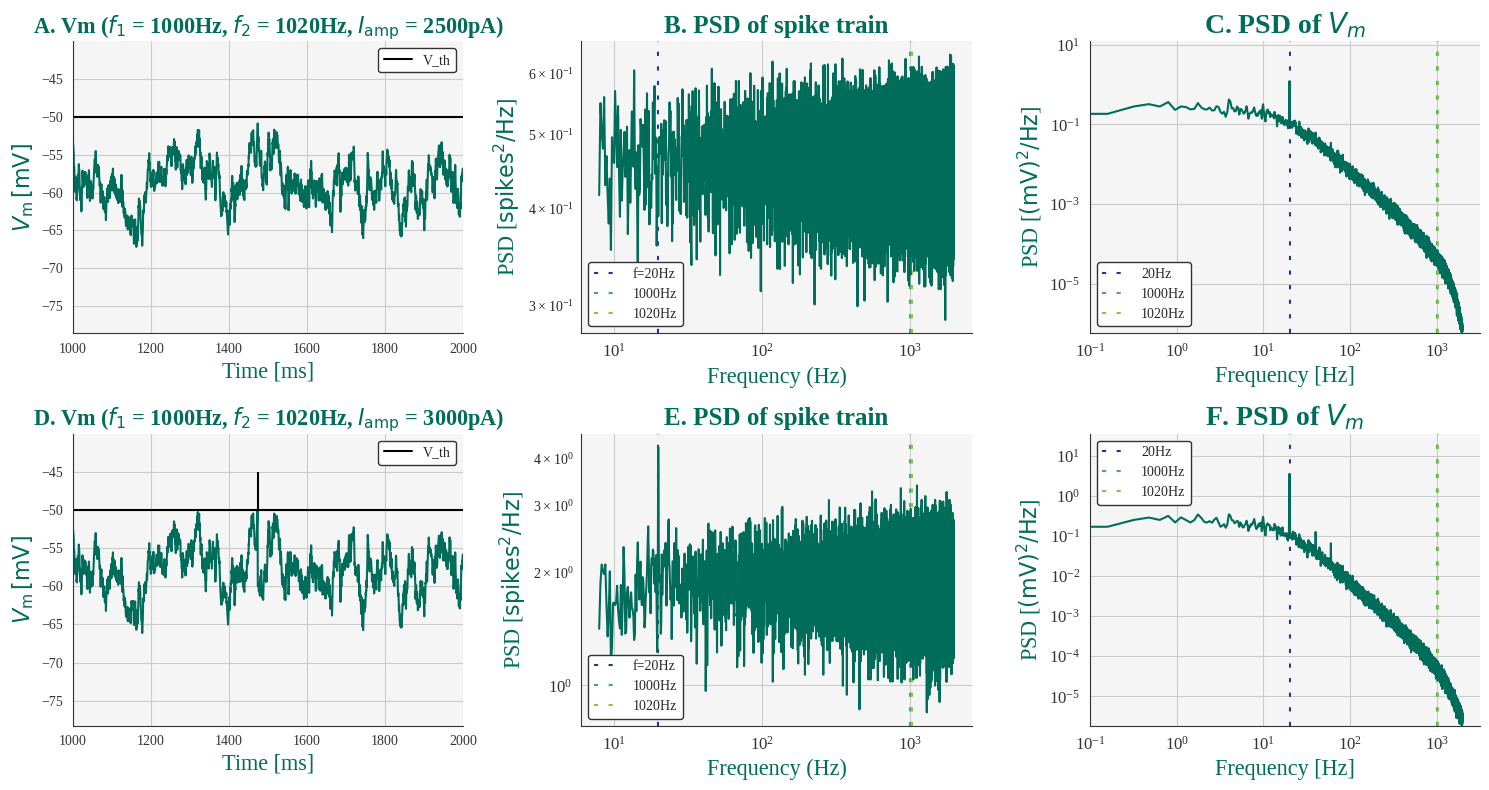

In [6]:
"""delay = 2ms. f=1000 og 1020"""
plot_results(sim_time=100e3,
             a_values=[2500, 3000],f_values=[1000], delay_sd=2, delay_mean=5,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
            save_fig=True, log=True, resolution=0.25, weight=1)

max V -50.0009002959835
I_syn_ex: 176.5612117266672
POPULATION SPIKE RATE: 3343.17
10 FØRSTE FREQS [8.   8.16 8.32 8.48 8.64 8.8  8.96 9.12 9.28 9.44]
len psd values 12201, arg_f 6200
noise_avg for f 0.44965416880191617


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,2500,-50.0009,0.68,0.41,0.38,1449.12,0.91,0.45,0.22,0.9,0.5,3343.17


max V -50.004255557773064
I_syn_ex: 565.653050576094
POPULATION SPIKE RATE: 6033.96
10 FØRSTE FREQS [8.   8.16 8.32 8.48 8.64 8.8  8.96 9.12 9.28 9.44]
len psd values 12201, arg_f 6200
noise_avg for f 1.9516784446049402


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,3000,-50.004256,4.72,1.86,4.72,20.0,0.95,1.95,1.0,2.5,1.9,6033.96


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


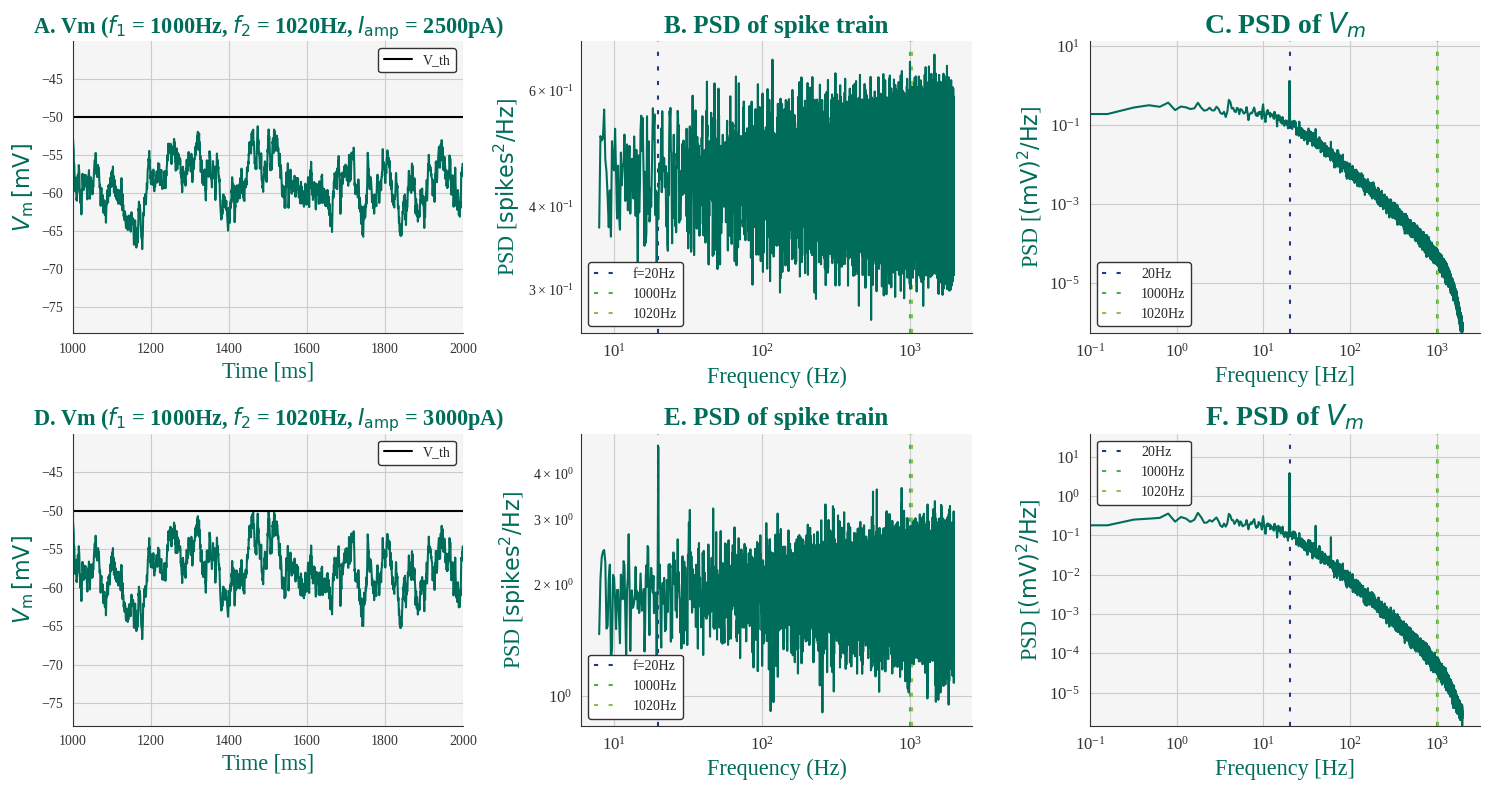

In [7]:
plot_results(sim_time=100e3,
             a_values=[2500, 3000],f_values=[1000], delay_sd=0, delay_mean=1,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
            save_fig=True, log=True, resolution=0.25, weight=1)

delay: [54.93386457 73.73840777 58.14736189 60.8699242  43.09680671 46.16755301
 45.34643488 59.8622648  35.05254857 37.39113996]
max V -50.000204246811386
I_syn_ex: 154.77307202230713
POPULATION SPIKE RATE: 6049.089999999999
10 FØRSTE FREQS [8.   8.16 8.32 8.48 8.64 8.8  8.96 9.12 9.28 9.44]
len psd values 12201, arg_f 6200
noise_avg for f 1.7109946595775722


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,3000,-50.000204,3.17,1.93,2.51,1201.6,1.13,1.71,0.82,1.5,1.7,6049.09


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main.png


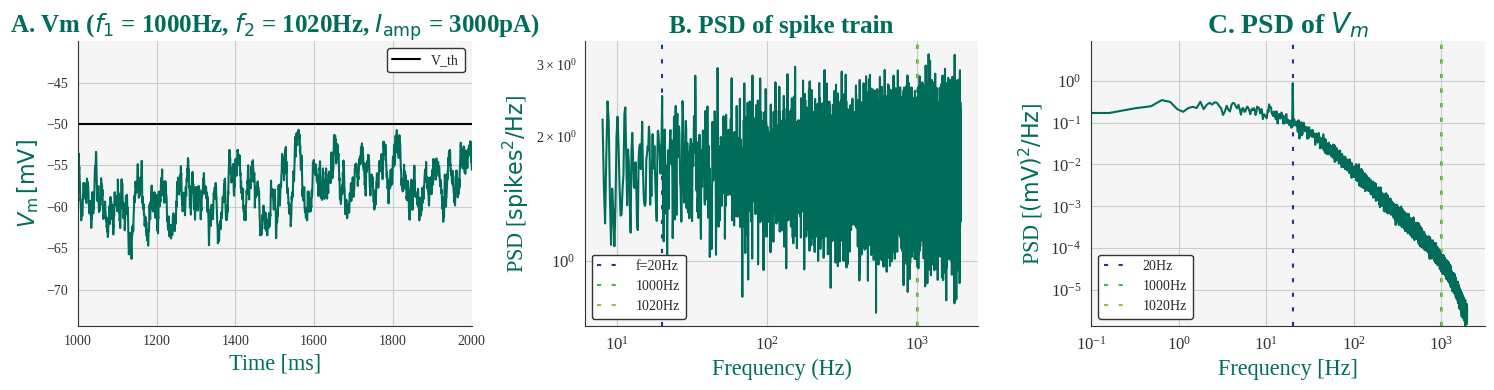

In [4]:
plot_results(sim_time=100e3,
             a_values=[3000],f_values=[1000], delay_sd=10, delay_mean=50,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
            save_fig=True, log=True, resolution=0.25, weight=1)